# MNIST classification example with TensorFlow

## Install packages on Google  Cloud Datalab (locally use conda env)

### Select in the Python3 Kernel:
In the menu bar the of 'Kernel', select   
**python3**
### Install needed packages
copy the command below in a Google Cloud Datalab cell  
**!pip install tensorflow==1.12**
### Restart the Kernel 
this is to take into account the new installed packages. Click in the menu bar on:  
**Reset Session**

## Include paths to our functions

In [1]:
import sys
import os
import pathlib

workingdir=os.getcwd()
print(workingdir)
d=[d for d in os.listdir(workingdir)]
n=0
while not set(['notebook']).issubset(set(d)):
   workingdir=str(pathlib.Path(workingdir).parents[0])
   print(workingdir)
   d=[d for d in os.listdir(str(workingdir))]
   n+=1
   if n>5:
       break
sys.path.insert(0, workingdir)
os.chdir(workingdir)

/Users/tarrade/Desktop/Work/Data_Science/Tutorials_Codes/Python/proj_DL_models_and_pipelines_with_GCP/notebook
/Users/tarrade/Desktop/Work/Data_Science/Tutorials_Codes/Python/proj_DL_models_and_pipelines_with_GCP


## Setup librairies import and plots style

### Import librairies

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import numpy as np
from skimage.io import imread
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report
from skimage.segmentation import mark_boundaries
from skimage.color import gray2rgb, rgb2gray, label2rgb
import _pickle as cPickle
import lime
from lime import lime_image
from random import sample, randint, shuffle
import time
import shutil
import glob
import re
import os
import codecs
import json 
import subprocess
import requests
import google.auth

In [3]:
print(tf.__version__)
print(tf.keras.__version__)

1.12.0
2.1.6-tf


### Import our utils functions

In [26]:
import src.utils.mnist_utils as mnist_utils
import src.utils.ml_utils as ml_utils
import src.utils.tensorflow_helper as tensorflow_helper
import src.model_mnist_v1.trainer.model as mnist_v1

In [40]:
import importlib
importlib.reload(mnist_utils)
importlib.reload(mnist_v1)
importlib.reload(ml_utils)
importlib.reload(tensorflow_helper);# to reload the function and mask the output

### Set plots style

In [8]:
print(plt.style.available)

['seaborn-dark', 'seaborn-darkgrid', 'seaborn-ticks', 'fivethirtyeight', 'seaborn-whitegrid', 'classic', '_classic_test', 'fast', 'seaborn-talk', 'seaborn-dark-palette', 'seaborn-bright', 'seaborn-pastel', 'grayscale', 'seaborn-notebook', 'ggplot', 'seaborn-colorblind', 'seaborn-muted', 'seaborn', 'Solarize_Light2', 'seaborn-paper', 'bmh', 'tableau-colorblind10', 'seaborn-white', 'dark_background', 'seaborn-poster', 'seaborn-deep']


In [9]:
# color code: https://matplotlib.org/gallery/color/named_colors.html#sphx-glr-gallery-color-named-colors-py
plt.style.use('seaborn-ticks')

## Data visualization of some examples per classes

### Loading dataset

In [10]:
path_train='data/mnist/numpy_train/'
path_test='data/mnist/numpy_test/'
x_train=cPickle.load(open(path_train+'x_train.pkl', 'rb'))
y_train=cPickle.load(open(path_train+'y_train.pkl', 'rb'))
x_test=cPickle.load(open(path_test+'x_test.pkl', 'rb'))
y_test=cPickle.load(open(path_test+'y_test.pkl', 'rb'))

### Looking at some example from training dataset

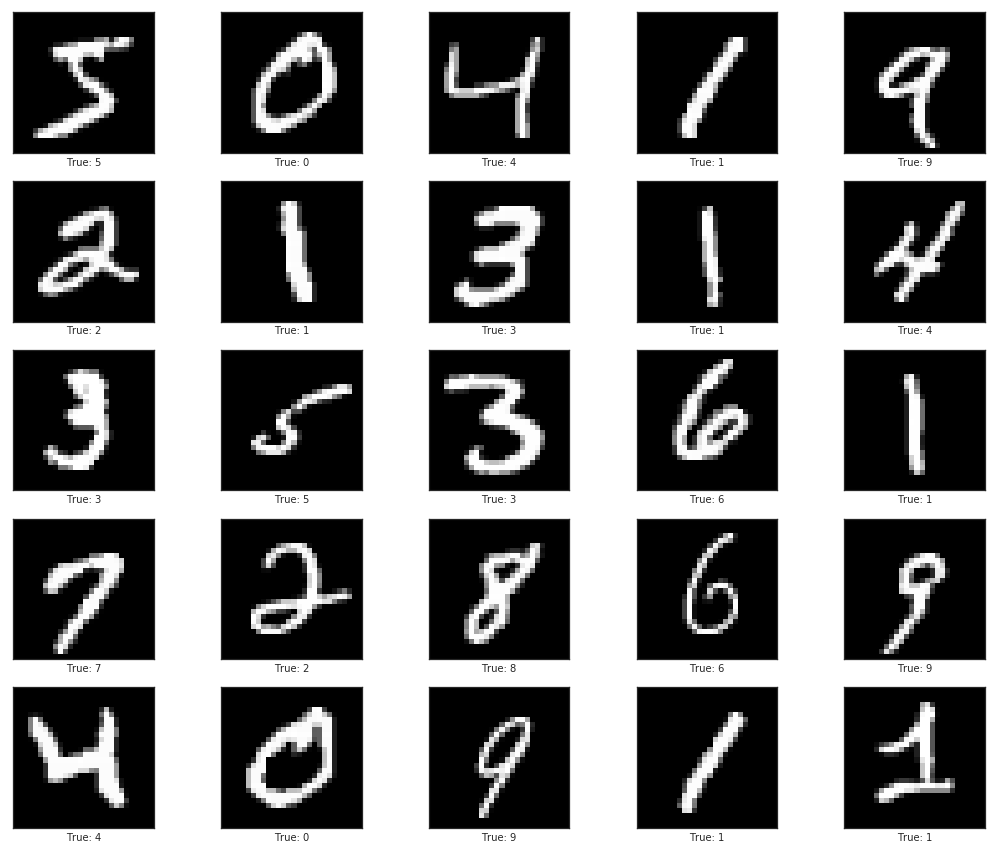

In [11]:
mnist_utils.plot_mnist_images(x_train[0:25], y_train[0:25])

## Set parameter

In [12]:
tf.logging.set_verbosity(tf.logging.INFO)

In [13]:
# number of classes
NUM_CLASSES =10

# dimension of the input data
DIM_INPUT = 784

# number of epoch to train our model
EPOCHS = 10

# size of our mini batch
BATCH_SIZE = 128

# shuffle buffer size
SHUFFLE_BUFFER_SIZE = 10 * BATCH_SIZE

# prefetch buffer size
PREFETCH_BUFFER_SIZE = tf.contrib.data.AUTOTUNE

# number of paralell calls
NUM_PARALELL_CALL = 4

# model version
MODEL='v1'

## Defined flags

In [132]:
tensorflow_helper.del_all_flags(tf.flags.FLAGS)

In [133]:
# just for jupyter notebook and avoir : "UnrecognizedFlagError: Unknown command line flag 'f'"
tf.app.flags.DEFINE_string('f', '', 'kernel') 

# path to store the model and input for Tensorboard and SavedModel
tf.app.flags.DEFINE_string('model_dir', 'results/Models/Mnist/tf_1_12/estimator/ckpt/', 'Dir to save a model and checkpoints')
tf.app.flags.DEFINE_string('saved_dir', 'results/Models/Mnist/tf_1_12/estimator/pt/', 'Dir to save a model for TF serving')

# path to store the model and input for Tensorboard
#tf.app.flags.DEFINE_string('model_dir_keras', './results/Models/Mnist/tf_1_12/keras/'+MODEL+'/ckpt/', 'Dir to save a model and checkpoints with keras')
#tf.app.flags.DEFINE_string('tensorboard_dir_keras', './results/Models/Mnist/tf_1_12/keras/'+MODEL+'/logs/', 'Dir to save logs for TensorBoard with keras')

# parameters for the input dataset and train the model
tf.app.flags.DEFINE_integer('epoch', EPOCHS, 'number of epoch')
tf.app.flags.DEFINE_integer('step_per_epoch', len(x_train) // BATCH_SIZE, 'number of step per epoch')
tf.app.flags.DEFINE_integer('batch_size', BATCH_SIZE, 'Batch size')
tf.app.flags.DEFINE_integer('shuffle_buffer_size', SHUFFLE_BUFFER_SIZE , 'Shuffle buffer size')
tf.app.flags.DEFINE_integer('prefetch_buffer_size', PREFETCH_BUFFER_SIZE, 'Prefetch buffer size')
tf.app.flags.DEFINE_integer('num_parallel_calls', NUM_PARALELL_CALL, 'Number of paralell calls')

# parameters for the model
tf.app.flags.DEFINE_integer('num_classes', NUM_CLASSES, 'number of classes in our model')
tf.app.flags.DEFINE_integer('dim_input', DIM_INPUT, 'dimension of the input data for our model')

FLAGS = tf.app.flags.FLAGS

In [134]:
print(FLAGS)


/Users/tarrade/anaconda3/envs/env_gcp_dl/lib/python3.6/site-packages/ipykernel_launcher.py:
  --batch_size: Batch size
    (default: '128')
    (an integer)
  --dim_input: dimension of the input data for our model
    (default: '784')
    (an integer)
  --epoch: number of epoch
    (default: '10')
    (an integer)
  --f: kernel
    (default: '')
  --model_dir: Dir to save a model and checkpoints
    (default: 'results/Models/Mnist/tf_1_12/estimator/ckpt/')
  --num_classes: number of classes in our model
    (default: '10')
    (an integer)
  --num_parallel_calls: Number of paralell calls
    (default: '4')
    (an integer)
  --prefetch_buffer_size: Prefetch buffer size
    (default: '-1')
    (an integer)
  --saved_dir: Dir to save a model for TF serving
    (default: 'results/Models/Mnist/tf_1_12/estimator/pt/')
  --shuffle_buffer_size: Shuffle buffer size
    (default: '1280')
    (an integer)
  --step_per_epoch: number of step per epoch
    (default: '468')
    (an integer)

absl.f

In [17]:
# pre defined flags
tf.estimator.ModeKeys.EVAL, tf.estimator.ModeKeys.PREDICT, tf.estimator.ModeKeys.TRAIN

('eval', 'infer', 'train')

### Printing the number relater to the number of events (epoch, batch size, ...)

In [21]:
def print_summary_input(data, step='training'):
    print('Summary for the {} dataset:'.format(step))
    if step=='training':
        print('  - number of epoch            :', FLAGS.epoch)
        print('  - number of events per epoch :', len(data))
        print('  - batch size                 :', FLAGS.batch_size)
        print('  - number of step per epoch   :', FLAGS.step_per_epoch)
        print('  - total number of steps      :', FLAGS.epoch * FLAGS.step_per_epoch)
    else:
        print('  - number of epoch            :', 1)
        print('  - number of events per epoch :', len(data))
        print('  - batch size                 :', None)
        print('  - number of step per epoch   :', 1)
        print('  - total number of steps      :', 1)  

In [22]:
print_summary_input(x_train)

Summary for the training dataset:
  - number of epoch            : 10
  - number of events per epoch : 60000
  - batch size                 : 128
  - number of step per epoch   : 468
  - total number of steps      : 4680


In [23]:
print_summary_input(x_test, 'testing')

Summary for the testing dataset:
  - number of epoch            : 1
  - number of events per epoch : 10000
  - batch size                 : None
  - number of step per epoch   : 1
  - total number of steps      : 1


## Machine Learning modelling with Keras

### Deleting existing models
delete fist the folder for a clean start

In [135]:
print('trained model will be saved here:\n', FLAGS.model_dir)

trained model will be saved here:
 results/Models/Mnist/tf_1_12/estimator/ckpt/


In [136]:
# deleting the folder from previous try 
shutil.rmtree(FLAGS.model_dir, ignore_errors=True)

In [137]:
print('trained model will be saved here:\n', FLAGS.saved_dir)

trained model will be saved here:
 results/Models/Mnist/tf_1_12/estimator/pt/


In [138]:
# deleting the folder from previous try 
shutil.rmtree(FLAGS.saved_dir, ignore_errors=True)

### Build the model

In [139]:
# reset the model
tf.keras.backend.clear_session()

In [140]:
# build the model
model_opt_tf = mnist_v1.keras_baseline_model(FLAGS, opt='tf')

# store the origina weights
initial_weights = model_opt_tf.get_weights()

### Check the nuber of parameters

In [141]:
model_opt_tf.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________


### Check input and output layer names

In [142]:
model_opt_tf.input_names # Use this name as the dictionary key in the TF input function

['dense_input']

In [143]:
model_opt_tf.output_names

['dense_2']

## Training and inference using  tf.estimator and tf.data.dataset

- **batch_size** determines the number of samples in each mini batch. Its maximum is the number of all samples, which makes gradient descent accurate, the loss will decrease towards the minimum if the learning rate is small enough, but iterations are slower. Its minimum is 1, resulting in stochastic gradient descent: Fast but the direction of the gradient step is based only on one example, the loss may jump around. batch_size allows to adjust between the two extremes: accurate gradient direction and fast iteration. Also, the maximum value for batch_size may be limited if your model + data set does not fit into the available (GPU) memory.
- **steps_per_epoch** the number of batch iterations before a training epoch is considered finished. If you have a training set of fixed size you can ignore it but it may be useful if you have a huge data set or if you are generating random data augmentations on the fly, i.e. if your training set has a (generated) infinite size. If you have the time to go through your whole training data set I recommend to skip this parameter.
- **validation_steps** similar to steps_per_epoch but on the validation data set instead on the training data. If you have the time to go through your whole validation data set I recommend to skip this parameter.



### Create some helper function

In [144]:
class TimeHistory(tf.train.SessionRunHook):
    def begin(self):
        self.times = []

    def before_run(self, run_context):
        self.iter_time_start = time.time()

    def after_run(self, run_context, run_values):
        self.times.append(time.time() - self.iter_time_start)

In [145]:
time_hist = TimeHistory()

### Use tf.distribute.startegy work across multiple devices/machines

In [146]:
# the tf.distribute.Strategy API is an easy way to distribute your training across multiple devices/machines

#strategy=None
## work with Keras with tf.train optimiser not tf.keras
strategy = tf.contrib.distribute.OneDeviceStrategy('device:CPU:0')
#strategy = tf.contrib.distribute.OneDeviceStrategy('device:GPU:0')
#NUM_GPUS = 2
#strategy = tf.contrib.distribute.MirroredStrategy(num_gpus=NUM_GPUS)
#strategy = tf.contrib.distribute.MirroredStrategy()

# config tf.estimator to use a give strategy
training_config = tf.estimator.RunConfig(train_distribute=strategy,
                                         model_dir=FLAGS.model_dir,
                                         save_summary_steps=20,
                                         save_checkpoints_steps=20)

INFO:tensorflow:Initializing RunConfig with distribution strategies.
INFO:tensorflow:Not using Distribute Coordinator.


### Transform a keras model to estimator model

In [147]:
# Set to the original weights for testing other pipelines
model_opt_tf.set_weights(initial_weights)

# transfor keras model to estimator model
estimator_train_model = tf.keras.estimator.model_to_estimator(keras_model=model_opt_tf,
                                                              config=training_config)

INFO:tensorflow:Using the Keras model provided.
INFO:tensorflow:Using config: {'_model_dir': 'results/Models/Mnist/tf_1_12/estimator/ckpt/', '_tf_random_seed': None, '_save_summary_steps': 20, '_save_checkpoints_steps': 20, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': <tensorflow.contrib.distribute.python.one_device_strategy.OneDeviceStrategy object at 0x1c61c33668>, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1c61c51c18>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1, '_distribute

### Input dataset
Use tf.data.dataset to feed the Keras model

In [148]:
# be sure you have the tfrecords file locally if you want to train localy (or get them from Cloud Storage)
path_test_tfrecords = 'data/mnist/tfrecord_numpy_test'
path_train_tfrecords = 'data/mnist/tfrecord_numpy_train'

Input dataset functions for training and testing will be pass during fit to load, convert, preprocess and reshuffle the images and labels 

### Fit the model

In [149]:
# Fit the model (using estimator.train and data.Dataset)
estimator_train_model.train(input_fn=lambda:mnist_v1.input_mnist_tfrecord_dataset_fn(glob.glob(path_train_tfrecords+'/train*.tfrecords'),
                                                                                     FLAGS,
                                                                                     mode=tf.estimator.ModeKeys.TRAIN,
                                                                                     batch_size=FLAGS.batch_size),
                            steps=1000,
                            hooks=[time_hist])

INFO:tensorflow:input_dataset_fn: TRAIN, train
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Warm-starting with WarmStartSettings: WarmStartSettings(ckpt_to_initialize_from='results/Models/Mnist/tf_1_12/estimator/ckpt/keras/keras_model.ckpt', vars_to_warm_start='.*', var_name_to_vocab_info={}, var_name_to_prev_var_name={})
INFO:tensorflow:Warm-starting from: ('results/Models/Mnist/tf_1_12/estimator/ckpt/keras/keras_model.ckpt',)
INFO:tensorflow:Warm-starting variable: dense/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dense/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dense_1/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dense_1/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dense_2/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dense_2/bias; prev_var_name: Unchanged
INFO:tensorflow:Create CheckpointSaverHook.
INFO

### Check the output created during the training
- creating a keras model will create the **keras** folder 
- **checkpoint** file
- **model.ckpt-xxx.meta** and **model.ckpt-xxx.data-yyyyy-of-zzzzz** and **model.ckpt-xxx.index** files
- Tensorflow graph to be display in TensorBoard **graph.pbtxt**
- logfile for TensorBoard **events.out.tfevents.xxxxxxxxxx**

In [153]:
for file in glob.glob(FLAGS.model_dir+'*'):
    print(re.findall(r'[^\\/]+|[\\/]',file)[-1])

keras
checkpoint
model.ckpt-940.data-00000-of-00001
model.ckpt-1000.data-00000-of-00001
model.ckpt-920.meta
events.out.tfevents.1551712210.Fabien-Tarrades-MacBook-Pro.local
model.ckpt-940.meta
model.ckpt-1000.meta
model.ckpt-960.meta
graph.pbtxt
model.ckpt-980.meta
model.ckpt-960.data-00000-of-00001
model.ckpt-920.index
model.ckpt-920.data-00000-of-00001
model.ckpt-980.data-00000-of-00001
model.ckpt-960.index
model.ckpt-980.index
model.ckpt-940.index
model.ckpt-1000.index


### TensorBoard

In [154]:
print('Tensorflow logs will be saved here:\n',FLAGS.model_dir)

Tensorflow logs will be saved here:
 results/Models/Mnist/tf_1_12/estimator/ckpt/


In [155]:
for file in glob.glob(FLAGS.model_dir+'*events.out.tfevents.*'):
    print(re.findall(r'[^\\/]+|[\\/]',file)[-1])

events.out.tfevents.1551712210.Fabien-Tarrades-MacBook-Pro.local


In [160]:
tensorboard_command='tensorboard --logdir "'+FLAGS.model_dir+'"'

In [172]:
print('In a separate shell with the same env activated (need Tensoflow and TensorBoard)')
print('  copy and pate the command below without ">>":')
print('  >>',tensorboard_command)


In a separate shell with the same env activated (need Tensoflow and TensorBoard)
  copy and pate the command below without ">>":
  >> tensorboard --logdir "results/Models/Mnist/tf_1_12/estimator/ckpt/"


## to be clean up

In [156]:
total_time = sum(time_hist.times)
print(f"total time with the current strategy: {total_time} seconds")

total time with the current strategy: 35.854407787323 seconds


In [157]:
avg_time_per_batch = np.mean(time_hist.times)
print(f"{BATCH_SIZE/avg_time_per_batch} images/second")

3569.993423382015 images/second


### Evaluate the model using Keras, tf.estimator and tf.data.dataset

In [108]:
score=estimator_train_model.evaluate(input_fn=lambda:input_dataset_fn(x_train,y_train, mode=tf.estimator.ModeKeys.TRAIN, batch_size=len(y_train)),
                                     steps=1)

INFO:tensorflow:input_dataset_fn: TRAIN, train
the number of epoch: num_epoch = 2
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-02-01-21:00:28
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ../results/Models/Mnist/tf_1_12/estimator/ckpt/model.ckpt-937
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2019-02-01-21:00:43
INFO:tensorflow:Saving dict for global step 937: accuracy = 0.97863334, global_step = 937, loss = 0.07083233
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 937: ../results/Models/Mnist/tf_1_12/estimator/ckpt/model.ckpt-937


In [109]:
score

{'accuracy': 0.97863334, 'loss': 0.07083233, 'global_step': 937}

In [110]:
print('Train loss:', score['loss'])
print('Train accuracy:', score['accuracy'])
print('Train global steps:', score['global_step'])

Train loss: 0.07083233
Train accuracy: 0.97863334
Train global steps: 937


In [111]:
score=estimator_train_model.evaluate(input_fn=lambda:input_dataset_fn(x_test, y_test,mode=tf.estimator.ModeKeys.EVAL, batch_size=len(x_test)))

INFO:tensorflow:input_dataset_fn: EVAL, eval
the number of epoch: num_epoch = 2
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-02-01-21:00:48
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ../results/Models/Mnist/tf_1_12/estimator/ckpt/model.ckpt-937
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-02-01-21:00:50
INFO:tensorflow:Saving dict for global step 937: accuracy = 0.9704, global_step = 937, loss = 0.098214075
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 937: ../results/Models/Mnist/tf_1_12/estimator/ckpt/model.ckpt-937


In [112]:
print('Test loss:', score['loss'])
print('Test accuracy:', score['accuracy'])
print('Test global steps:', score['global_step'])

Test loss: 0.098214075
Test accuracy: 0.9704
Test global steps: 937


### Prediction using the Keras model, tf.estimator and tf.data.dataset

In [113]:
predictions=list(estimator_train_model.predict(input_fn=lambda:input_dataset_fn(x_test, y_test,mode=tf.estimator.ModeKeys.EVAL, batch_size=len(x_test))))

INFO:tensorflow:input_dataset_fn: EVAL, eval
the number of epoch: num_epoch = 2
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ../results/Models/Mnist/tf_1_12/estimator/ckpt/model.ckpt-937
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [114]:
len(predictions)

20000

In [115]:
predictions[0].keys()

dict_keys(['dense_3'])

In [116]:
output_layer=model_opt_tf.output_names[0]

In [117]:
for i in range(10):
    prediction_array = predictions[i][output_layer]
    predicted_label = np.argmax(prediction_array)
    print('Actual label:', np.argmax(y_test[i]))
    print("Predicted label: ", predicted_label)

Actual label: 7
Predicted label:  7
Actual label: 2
Predicted label:  2
Actual label: 1
Predicted label:  1
Actual label: 0
Predicted label:  0
Actual label: 4
Predicted label:  4
Actual label: 1
Predicted label:  1
Actual label: 4
Predicted label:  4
Actual label: 9
Predicted label:  9
Actual label: 5
Predicted label:  5
Actual label: 9
Predicted label:  9


### Keras's model checks

In [118]:
model_opt_tf.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 784)               615440    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                7850      
Total params: 623,290
Trainable params: 623,290
Non-trainable params: 0
_________________________________________________________________


In [119]:
model_opt_tf.input_names

['dense_2_input']

In [120]:
model_opt_tf.output_names

['dense_3']

### Estimator's model checks

In [121]:
estimator_train_model.get_variable_names()

['dense_2/bias',
 'dense_2/bias/Adam',
 'dense_2/bias/Adam_1',
 'dense_2/kernel',
 'dense_2/kernel/Adam',
 'dense_2/kernel/Adam_1',
 'dense_3/bias',
 'dense_3/bias/Adam',
 'dense_3/bias/Adam_1',
 'dense_3/kernel',
 'dense_3/kernel/Adam',
 'dense_3/kernel/Adam_1',
 'global_step',
 'training/TFOptimizer/beta1_power',
 'training/TFOptimizer/beta2_power']

In [122]:
estimator_train_model.get_variable_value(estimator_train_model.get_variable_names()[0]).shape

(784,)

In [123]:
estimator_train_model.get_variable_value(estimator_train_model.get_variable_names()[1]).shape

(784,)

In [124]:
estimator_train_model.latest_checkpoint()

'../results/Models/Mnist/tf_1_12/estimator/ckpt/model.ckpt-937'

## Model serving using Keras, tf.estimator and tf.data.dataset

In [152]:
for file in glob.glob(FLAGS.saved_dir+'*'):
    print(re.findall(r'[^\\/]+|[\\/]',file)[-1])

In [126]:
shutil.rmtree(FLAGS.saved_dir, ignore_errors=True)

In [127]:
model_opt_tf.input_names

['dense_2_input']

In [128]:
def serving_input_receiver_fn():
    """Serving input_fn that builds features from placeholders#

    Returns
    -------
    tf.estimator.export.ServingInputReceiver
    """
    input_images = tf.placeholder(tf.float32, [None, 784])
    features = {'dense_2_input' : input_images} # this is the dict that is then passed as "features" parameter to your model_fn
    receiver_tensors = {'dense_2_input': input_images} # As far as I understand this is needed to map the input to a name you can retrieve later
   
    return tf.estimator.export.ServingInputReceiver(features, receiver_tensors)

In [129]:
if not os.path.exists(FLAGS.saved_dir):
    os.makedirs(FLAGS.saved_dir)

In [130]:
# Option 2: Only export predict mode
estimator_train_model.export_saved_model(os.path.abspath(FLAGS.saved_dir), 
                                         serving_input_receiver_fn=serving_input_receiver_fn)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: ['serving_default']
INFO:tensorflow:Signatures INCLUDED in export for Train: None
INFO:tensorflow:Signatures INCLUDED in export for Eval: None
INFO:tensorflow:Restoring parameters from ../results/Models/Mnist/tf_1_12/estimator/ckpt/model.ckpt-937
Instructions for updating:
Pass your op to the equivalent parameter main_op instead.
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: /Users/tarrade/Desktop/Work/Data_Science/Tutorials_Codes/Python/proj_DL_models_and_pipelines_with_GCP/results/Models/Mnist/tf_1_12/estimator/pt/temp-b'1549054852'/saved_model.pb


b'/Users/tarrade/Desktop/Work/Data_Science/Tutorials_Codes/Python/proj_DL_models_and_pipelines_with_GCP/results/Models/Mnist/tf_1_12/estimator/pt/1549054852'

In [563]:
for file in glob.glob(FLAGS.saved_dir+'*'):
    print(re.findall(r'[^\\/]+|[\\/]',file)[-1])

1549054852


**Update the model id in the path below with the correct one from above i.e'1549040172'**

In [564]:
model_tag='1549054852'
os.environ['MODEL_FOR_SERVING']=FLAGS.saved_dir+model_tag+'/'

In [565]:
# replace the folder name below with the one from above i.e '1549040172'
for file in glob.glob(FLAGS.saved_dir+model_tag+'/*'):
    print(re.findall(r'[^\\/]+|[\\/]',file)[-1])

variables
saved_model.pb


## Check the saved model before serving 

In [566]:
tf.saved_model.signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY,

('serving_default',)

In [568]:
! saved_model_cli show --dir $MODEL_FOR_SERVING --tag serve --signature_def serving_default

The given SavedModel SignatureDef contains the following input(s):
  inputs['dense_2_input'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 784)
      name: Placeholder:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['dense_3'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 10)
      name: dense_3/Softmax:0
Method name is: tensorflow/serving/predict


## Use Cloud ML Engine

### Checking gcloud installation (SDK)

In [272]:
os.environ['CLOUDSDK_PYTHON']='/Users/tarrade/anaconda3/bin/python'

### Create a input json file and string

Input needed to get prediction using ml-engine an option --json-instances: 'dense_2_input' for each new entry

In [664]:
input_prediction=x_test[0:3]

In [665]:
data = input_prediction.tolist()
json_file = "../data/input_predict_gcloud.json" 

with codecs.open(json_file, 'w', encoding='utf-8') as f:
    for el in data:
        instance = {'dense_2_input': el}
        json.dump(instance, f , sort_keys=True)
        f.write("\n")

Input needed to get prediction using ml-engine and cURL

In [666]:
data = input_prediction.tolist()
json_file = "../data/input_predict_cURL.json" 

with codecs.open(json_file, 'w', encoding='utf-8') as f:
    tmp={}
    list_tmp=[]
    for el in data:
        tmp['dense_2_input']=el
        list_tmp.append(tmp)
    instance = {"instances": list_tmp}    
    json.dump(instance, f , sort_keys=True)
    f.write("\n")

In [676]:
input_predict_request = json.dumps({"signature_name": "serving_default", "instances": input_prediction.tolist()})

display example

In [278]:
def show(img, title):
    plt.figure()
    plt.imshow(img.reshape(28,28))
    plt.axis('off')
    plt.title('\n\n{}'.format(title), fontdict={'size': 16})

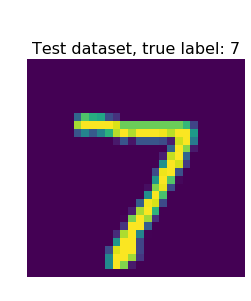

In [515]:
for i in range(1):
    show(x_test[i],'Test dataset, true label: '+str(np.argmax(y_test[i])))

### Test the model inference using gcloud locally

In [670]:
os.environ['CLOUDSDK_PYTHON']='/Users/tarrade/anaconda3/bin/python'

In [671]:
!gcloud ml-engine local predict --model-dir $MODEL_FOR_SERVING --json-instances ../data/input_predict_gcloud.json 

2019-02-07 14:47:57.372739: I tensorflow/core/common_runtime/process_util.cc:69] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.

DENSE_3
[5.820228579977993e-06, 2.2560351453648764e-07, 3.986712181358598e-05, 0.00012092345423297957, 1.6469396513230095e-08, 4.26365613748203e-06, 4.727720437358585e-10, 0.999786913394928, 7.320999429794028e-06, 3.4697757655521855e-05]
[1.374597104586428e-05, 0.004179574083536863, 0.9947308301925659, 0.0008424344123341143, 4.2751646667227305e-10, 0.00018749698938336223, 1.1633811482170131e-05, 2.49833398413557e-09, 3.442165325395763e-05, 7.398723300688914e-10]
[1.2485852494137362e-05, 0.9962553977966309, 0.000608675240073353, 0.0001076246626325883, 0.0008343913941644132, 0.00012625956151168793, 2.7262765797786415e-05, 0.0016017641173675656, 0.00036735867615789175, 5.882246477995068e-05]


### Deploy the model using Cloud ML Engine
- https://cloud.google.com/ml-engine/docs/v1/predict-request
- https://cloud.google.com/ml-engine/docs/tensorflow/online-predict#requesting_predictions

In [587]:
os.environ['PROJECT']=subprocess.run('gcloud config list project --format "value(core.project)"', shell=True, check=True, stdout=subprocess.PIPE).stdout.decode().replace('\n', '')
os.environ['MODEL']='mnist'
os.environ['BUCKET']='gs://'+os.environ['PROJECT']
os.environ['VERSION']='v2'

In [581]:
# gsutil need python 2.7
os.environ['CLOUDSDK_PYTHON']='/Users/tarrade/anaconda/bin/python'

In [585]:
!gsutil cp -r $MODEL_FOR_SERVING $BUCKET/model_dir_tmp/

Copying file://../results/Models/Mnist/tf_1_12/estimator/pt/1549054852/saved_model.pb [Content-Type=application/octet-stream]...
Copying file://../results/Models/Mnist/tf_1_12/estimator/pt/1549054852/variables/variables.data-00000-of-00001 [Content-Type=application/octet-stream]...
Copying file://../results/Models/Mnist/tf_1_12/estimator/pt/1549054852/variables/variables.index [Content-Type=application/octet-stream]...
\ [3 files][  2.4 MiB/  2.4 MiB]                                                
Operation completed over 3 objects/2.4 MiB.                                      


In [592]:
!gcloud ml-engine models list

NAME   DEFAULT_VERSION_NAME
mnist  v1


when creating the model for the first time

create a version and store the model

In [595]:
!gcloud ml-engine versions create ${VERSION} \
--model ${MODEL} \
--origin=${BUCKET}/model_dir_tmp/1549054852 \
--runtime-version=1.12 \
--staging-bucket=${BUCKET}

ERROR: (gcloud.ml-engine.versions.create) ALREADY_EXISTS: Field: version.name Error: A version with the same name already exists.
- '@type': type.googleapis.com/google.rpc.BadRequest
  fieldViolations:
  - description: A version with the same name already exists.
    field: version.name


#### Checking the list of model in ML-Engine

In [605]:
!gcloud ml-engine models list

NAME   DEFAULT_VERSION_NAME
mnist  v1


In [610]:
 !gcloud ml-engine versions list --model mnist

NAME  DEPLOYMENT_URI                                              STATE
v1    gs://ml-productive-pipeline-53122/model_dir_tmp/1549054852  READY
v2    gs://ml-productive-pipeline-53122/model_dir_tmp/1549054852  READY


#### Testing our model using ML-Engine

In [672]:
!gcloud ml-engine predict --model=${MODEL} --version=${VERSION} --json-instances ../data/input_predict_gcloud.json

DENSE_3
[5.820239039167063e-06, 2.2560371348845365e-07, 3.9867194573162124e-05, 0.00012092355609638616, 1.6469426711296364e-08, 4.263659775460837e-06, 4.727719882247072e-10, 0.9997867941856384, 7.321012162719853e-06, 3.4697819501161575e-05]
[1.3745981959800702e-05, 0.004179579671472311, 0.9947307109832764, 0.0008424347033724189, 4.275147735821605e-10, 0.00018749696027953178, 1.163381057267543e-05, 2.4983288771096568e-09, 3.442161687416956e-05, 7.39872219046589e-10]
[1.2485862498579081e-05, 0.9962552785873413, 0.0006086757639423013, 0.00010762474994407967, 0.0008343925583176315, 0.00012625991075765342, 2.7262842195341364e-05, 0.0016017662128433585, 0.0003673589671961963, 5.8822570281336084e-05]


#### Testing using RESTful API 
- https://www.tensorflow.org/serving/api_rest  
RESTful API is an application program interface (API) that uses HTTP requests to GET, PUT, POST and DELETE data (Json)

Use cURL

In [673]:
!curl https://ml.googleapis.com/v1/projects/${PROJECT}/models/${MODEL}/versions/${VERSION} \
-H "Authorization: Bearer $(gcloud auth print-access-token)" \

{
  "name": "projects/ml-productive-pipeline-53122/models/mnist/versions/v2",
  "deploymentUri": "gs://ml-productive-pipeline-53122/model_dir_tmp/1549054852",
  "createTime": "2019-02-07T11:00:51Z",
  "lastUseTime": "2019-02-07T13:48:20Z",
  "runtimeVersion": "1.12",
  "state": "READY",
  "etag": "KoHdxAqPbTQ=",
  "framework": "TENSORFLOW",
  "machineType": "mls1-c1-m2",
  "pythonVersion": "2.7"
}


In [674]:
!curl -X POST \
https://ml.googleapis.com/v1/projects/${PROJECT}/models/${MODEL}/versions/${VERSION}:predict \
-H "Content-Type: application/json" \
-H "Authorization: Bearer $(gcloud auth print-access-token)" \
-d @../data/input_predict_cURL.json 

{"predictions": [{"dense_3": [1.2485862498579081e-05, 0.9962552785873413, 0.0006086757639423013, 0.00010762474994407967, 0.0008343925583176315, 0.00012625991075765342, 2.7262842195341364e-05, 0.0016017662128433585, 0.00036735893809236586, 5.8822570281336084e-05]}, {"dense_3": [1.2485862498579081e-05, 0.9962552785873413, 0.0006086757639423013, 0.00010762474994407967, 0.0008343925583176315, 0.00012625991075765342, 2.7262842195341364e-05, 0.0016017662128433585, 0.00036735893809236586, 5.8822570281336084e-05]}, {"dense_3": [1.2485862498579081e-05, 0.9962552785873413, 0.0006086757639423013, 0.00010762474994407967, 0.0008343925583176315, 0.00012625991075765342, 2.7262842195341364e-05, 0.0016017662128433585, 0.0003673589671961963, 5.8822570281336084e-05]}]}

Use python and requests

In [686]:
url = 'https://ml.googleapis.com/v1/projects/'+os.environ['PROJECT']+'/models/'+os.environ['MODEL']+'/versions/'+os.environ['VERSION']+':predict'

headers = {
    'Content-Type': 'application/json',
    'Authorization':  'Bearer {}'.format(subprocess.run('gcloud auth print-access-token', shell=True, check=True, stdout=subprocess.PIPE).stdout.decode().replace('\n', ''))
}

json_response = requests.post(url=url, data=input_predict_request, headers=headers)
json.loads(json_response.text)

{'predictions': [{'dense_3': [5.820239039167063e-06,
    2.2560371348845365e-07,
    3.9867194573162124e-05,
    0.00012092355609638616,
    1.6469426711296364e-08,
    4.263659775460837e-06,
    4.727719882247072e-10,
    0.9997867941856384,
    7.321012162719853e-06,
    3.4697819501161575e-05]},
  {'dense_3': [1.3745981959800702e-05,
    0.004179579671472311,
    0.9947307109832764,
    0.0008424347033724189,
    4.275147735821605e-10,
    0.00018749696027953178,
    1.163381057267543e-05,
    2.4983288771096568e-09,
    3.442161687416956e-05,
    7.39872219046589e-10]},
  {'dense_3': [1.2485862498579081e-05,
    0.9962552785873413,
    0.0006086757639423013,
    0.00010762474994407967,
    0.0008343925583176315,
    0.00012625991075765342,
    2.7262842195341364e-05,
    0.0016017662128433585,
    0.0003673589671961963,
    5.8822570281336084e-05]}]}

In [1]:
predictions = json.loads(json_response.text)['predictions']

NameError: name 'json_response' is not defined

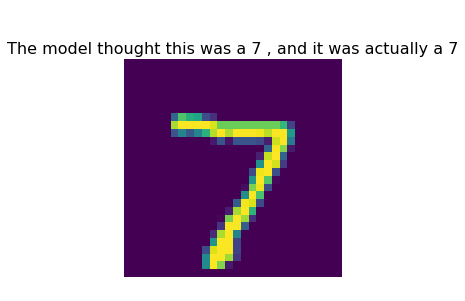

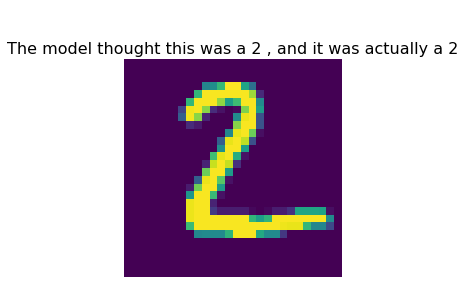

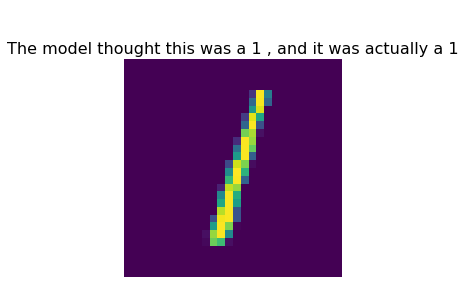

In [688]:
for i in range(0,3):
    show(x_test[i], 'The model thought this was a {} , and it was actually a {}'.format(np.argmax(predictions[i]['dense_3']),np.argmax(y_test[i])))

#### Testing using gRPC API 
- https://cloud.google.com/endpoints/docs/grpc/about-grpc  
gRPC is a high performance, open-source universal RPC framework, developed by Google. In gRPC, a client application can directly call methods on a server application on a different machine as if it was a local object, making it easier to create distributed applications and services (Protobuf)

In [552]:
# to do

## Debug Python environment

In [553]:
!python -c "import tensorflow as tf; print(tf.GIT_VERSION, tf.VERSION)"

b'unknown' 1.12.0


In [153]:
!conda list

# packages in environment at /Users/tarrade/anaconda3/envs/env_gcp_dl:
#
# Name                    Version                   Build  Channel
_tflow_select             2.3.0                       mkl  
absl-py                   0.7.0                    py36_0  
altair                    2.3.0                    pypi_0    pypi
appnope                   0.1.0            py36hf537a9a_0  
asn1crypto                0.24.0                   py36_0  
astor                     0.7.1                    py36_0  
astroid                   2.1.0                    py36_0  
atomicwrites              1.2.1                    py36_0  
attrs                     18.2.0           py36h28b3542_0  
autopep8                  1.4.3                    py36_0  
backcall                  0.1.0                    py36_0  
blas                      1.1                    openblas    conda-forge
bleach                    3.1.0                    pypi_0    pypi
c-ares                    1.15.0               h1de35cc

In [1]:
## Reload the model and make evaluation using Keras

In [ ]:
reload_model_opt_keras=tf.keras.models.load_model(FLAGS.model_dir_keras+'keras_model.h5')

In [ ]:
score = reload_model_opt_keras.evaluate(x_train, 
                                        y_train, 
                                        verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

In [ ]:
### Evaluate the model using Keras and tf.data.dataset

In [ ]:
score = model_opt_keras.evaluate(x_test, 
                       y_test, 
                       verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
score = model_opt_keras.evaluate(x_train, 
                       y_train, 
                       verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

In [ ]:
for i in range(0,3):
    show(x_test[i], 'The model thought this was a {} , and it was actually a {}'.format(np.argmax(predictions[i]['dense_3']),np.argmax(y_test[i])))